In [1]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import pandas as pd

from tqdm import tqdm
from vit_prisma.models.base_vit import HookedViT

import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

e:\Anaconda\envs\acv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
data_df = pd.read_csv('generated_images/data.csv')
data_df

,num_shapes,shape_0,color_0,position_0,filename,shape_1,color_1,position_1,shape_2,color_2,position_2,shape_3,color_3,position_3,shape_4,color_4,position_4
0,1,pentagon,red,BL,generated_images/image_1_shapes_0.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,pentagon,red,BR,generated_images/image_1_shapes_1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,square,red,TR,generated_images/image_1_shapes_2.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,hexagon,black,M,generated_images/image_1_shapes_3.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,square,blue,M,generated_images/image_1_shapes_4.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,pentagon,blue,BR,generated_images/image_5_shapes_95.png,triangle,black,BL,hexagon,yellow,M,square,green,TL,circle,pink,TR
496,5,pentagon,pink,BR,generated_images/image_5_shapes_96.png,hexagon,yellow,BL,circle,red,TL,square,blue,M,triangle,green,TR
497,5,triangle,blue,M,generated_images/image_5_shapes_97.png,hexagon,pink,BR,circle,green,TL,pentagon,red,TR,square,yellow,BL
498,5,square,yellow,BL,generated_images/image_5_shapes_98.png,hexagon,red,BR,triangle,pink,TL,circle,blue,M,pentagon,black,TR


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def get_all_embeddings(model, filenames):
    all_embeddings = {}
    for filename in tqdm(filenames):
        image = Image.open(filename)
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs, cache = model.run_with_cache(image)
        all_embeddings[filename] = outputs[0].cpu().numpy()
    return all_embeddings

In [6]:
EMBEDDINGS_FILE = "embeddings.pkl"

In [7]:
if not os.path.exists(EMBEDDINGS_FILE):
    print("Loading images and getting embeddings...")
    clip_model = HookedViT.from_pretrained("openai/clip-vit-large-patch14", is_clip=True, is_timm=False)
    clip_model = clip_model.to(device)

    image_embeddings = get_all_embeddings(clip_model, data_df['filename'].values)
    with open(EMBEDDINGS_FILE, "wb") as f:
        pickle.dump(image_embeddings, f)

In [8]:
image_embeddings = pickle.load(open(EMBEDDINGS_FILE, "rb"))

In [9]:
feature_names = ['BL', 'BR', 'M', 'TL', 'TR', 'black', 'blue', 'circle', 'green', 'hexagon', 'pentagon', 'pink', 'red', 'square', 'triangle', 'yellow']
# feature_names = ['black', 'blue', 'circle', 'green', 'hexagon', 'pentagon', 'pink', 'red', 'square', 'triangle', 'yellow']

In [10]:
# feature_names = ['circle', 'pink', 'blue']

In [11]:
def is_feature_present(row, feature1):
    shapes_in_img = [row[f'shape_{i}'] for i in range(5) if pd.notna(row[f'shape_{i}'])]
    colors_in_img = [row[f'color_{i}'] for i in range(5) if pd.notna(row[f'color_{i}'])]
    positions_in_img = [row[f'position_{i}'] for i in range(5) if pd.notna(row[f'position_{i}'])]

    return ((feature1 in shapes_in_img) or (feature1 in colors_in_img) or (feature1 in positions_in_img))

In [12]:
def find_overlap_metrics(tensor_dict, df, feature1, feature2):
    # Extract filenames that exist in both the tensor dict and dataframe
    common_filenames = set(tensor_dict.keys()) & set(df['filename'])
    
    if not common_filenames:
        raise ValueError("No common filenames found between tensor_dict and dataframe")
    
    # Convert tensors to a list and keep track of corresponding filenames
    tensor_list = []
    filenames_list = []
    
    for filename in common_filenames:
        tensor = tensor_dict[filename]
        # Make sure tensor is flattened to 1D for TSNE input
        tensor_list.append(tensor.reshape(1, -1)[0])
        filenames_list.append(filename)
    
    # Stack tensors into a single numpy array
    tensor_array = np.stack(tensor_list)
    
    # Create a mapping from filename to category
    filename_to_category = dict(zip(df['filename'], df['category']))
    
    # Get categories for the selected filenames
    categories = [filename_to_category[filename] for filename in filenames_list]
    
    # Create a DataFrame for easy plotting
    plot_df = pd.DataFrame({
        'filename': filenames_list,
        'category': categories,
        'embedding': tensor_array.tolist()
    })

    # Compute mean points for each category
    mean_points = plot_df.groupby('category')['embedding'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()

    # print(mean_points)

    point_1 = mean_points.iloc[0][['embedding']].values[0]
    point_2 = mean_points.iloc[1][['embedding']].values[0]
    
    distance = np.linalg.norm(point_1 - point_2)
    print(f"Distance between {feature1} and {feature2}: {distance}")

    # With the mean points, assign the nearest mean point to each original point
    embeddings_array = np.stack(plot_df['embedding'].values)  # Convert list of arrays to a 2D numpy array
    mean_embeddings_array = np.stack(mean_points['embedding'].values)  # Convert mean embeddings to a 2D numpy array

    distances = np.linalg.norm(embeddings_array[:, np.newaxis] - mean_embeddings_array, axis=2)

    nearest_mean_indices = np.argmin(distances, axis=1)
    plot_df['nearest_mean'] = mean_points['category'].iloc[nearest_mean_indices].values
    plot_df['misclassification'] = plot_df['category'] != plot_df['nearest_mean']
    misclassification_rate = plot_df['misclassification'].mean()
    print(f"Misclassification rate: {misclassification_rate:.2f}")
    return distance, misclassification_rate

In [13]:
num_pairs = len(feature_names) * (len(feature_names) - 1) // 2
print(f"Number of pairs: {num_pairs}")
# fig, axs = plt.subplots(num_pairs, 1, figsize=(5, 3 * num_pairs), constrained_layout=True)
ax_idx = 0

dists = {}

for i in range(len(feature_names)):
    feature1 = feature_names[i]
    for j in range(i + 1, len(feature_names)):
        feature2 = feature_names[j]
        print(f"Processing pair {ax_idx + 1}: {feature1}, {feature2}")
        
        feature_data_df = data_df.copy()

        feature_data_df['category'] = feature_data_df.apply(lambda x: is_feature_present(x, feature1), axis=1) + feature_data_df.apply(lambda x: is_feature_present(x, feature2), axis=1) * 2

        feature_data_df = feature_data_df[feature_data_df['category'].isin([1, 2])]

        dist, misclassification_rate = find_overlap_metrics(image_embeddings, feature_data_df, feature1, feature2)

        dists[(feature1, feature2)] = (dist, misclassification_rate)
        ax_idx += 1

# plt.tight_layout()
# plt.show()

Number of pairs: 120
Processing pair 1: BL, BR
Distance between BL and BR: 1.3409240879242081
Misclassification rate: 0.39
Processing pair 2: BL, M
Distance between BL and M: 2.7172912691030424
Misclassification rate: 0.14
Processing pair 3: BL, TL
Distance between BL and TL: 1.4644199642962463
Misclassification rate: 0.29
Processing pair 4: BL, TR
Distance between BL and TR: 1.5646863774348911
Misclassification rate: 0.24
Processing pair 5: BL, black
Distance between BL and black: 5.202313115010022
Misclassification rate: 0.14
Processing pair 6: BL, blue
Distance between BL and blue: 3.425240499080673
Misclassification rate: 0.02
Processing pair 7: BL, circle
Distance between BL and circle: 3.615103144656902
Misclassification rate: 0.19
Processing pair 8: BL, green
Distance between BL and green: 3.165228762618944
Misclassification rate: 0.17
Processing pair 9: BL, hexagon
Distance between BL and hexagon: 4.2114559897867085
Misclassification rate: 0.06
Processing pair 10: BL, pentagon


In [14]:
# Print distances in descending order
sorted_dists = sorted(dists.items(), key=lambda x: x[1])
for pair, (dist, misclassification_rate) in sorted_dists:
    feature1, feature2 = sorted(pair)
    print(f"Feature pair: {feature1} and {feature2}: {dist:.4f}, Misclassification rate: {misclassification_rate:.4f}")

Feature pair: TL and TR: 1.0839, Misclassification rate: 0.3744
Feature pair: BL and BR: 1.3409, Misclassification rate: 0.3909
Feature pair: BL and TL: 1.4644, Misclassification rate: 0.2921
Feature pair: BL and TR: 1.5647, Misclassification rate: 0.2429
Feature pair: BR and TR: 1.6623, Misclassification rate: 0.3429
Feature pair: BR and TL: 1.8263, Misclassification rate: 0.3166
Feature pair: M and TR: 2.3339, Misclassification rate: 0.1465
Feature pair: M and TL: 2.3425, Misclassification rate: 0.0854
Feature pair: BR and red: 2.6214, Misclassification rate: 0.1969
Feature pair: green and red: 2.6779, Misclassification rate: 0.0042
Feature pair: BL and M: 2.7173, Misclassification rate: 0.1407
Feature pair: BR and M: 2.7998, Misclassification rate: 0.0880
Feature pair: BR and green: 2.8326, Misclassification rate: 0.0684
Feature pair: pink and yellow: 2.9610, Misclassification rate: 0.1629
Feature pair: pink and red: 2.9789, Misclassification rate: 0.0823
Feature pair: TL and yellow

In [15]:
# Save the distances to a CSV file
pair_dists_info = []
for pair, (dist, misclassification_rate) in sorted_dists:
    feature1, feature2 = sorted(pair)
    pair_dists_info.append({
        'feature1': feature1,
        'feature2': feature2,
        'distance': dist,
        'misclassification_rate': misclassification_rate
    })
pair_dists_df = pd.DataFrame(pair_dists_info)
pair_dists_df.head()

,feature1,feature2,distance,misclassification_rate
0,TL,TR,1.083875,0.374384
1,BL,BR,1.340924,0.390863
2,BL,TL,1.464420,0.292079
3,BL,TR,1.564686,0.242938
4,BR,TR,1.662264,0.342857


In [16]:
pair_dists_df.to_csv("feature_pairs_full_embds_dists.csv", index=False)

In [17]:
pair_dists_df = pd.read_csv("feature_pairs_full_embds_dists.csv")

In [18]:
pair_ratios_df = pd.read_csv("feature_pairs_ratios_100.csv")
pair_ratios_df.head()

,feature1,feature2,sum_ratios,neuron_count
0,M,circle,26.265038,53
1,circle,pink,24.447719,34
2,M,pink,23.936011,39
3,circle,pentagon,20.007878,1
4,circle,square,19.751926,11


In [19]:
# combine the two dataframes on feature_1 and feature_2
combined_df = pd.merge(pair_dists_df, pair_ratios_df, on=['feature1', 'feature2'], how='inner')
combined_df.head()

,feature1,feature2,distance,misclassification_rate,sum_ratios,neuron_count
0,TL,TR,1.083875,0.374384,8.661481,0
1,BL,BR,1.340924,0.390863,11.795187,6
2,BL,TL,1.464420,0.292079,12.073950,0
3,BL,TR,1.564686,0.242938,8.554600,0
4,BR,TR,1.662264,0.342857,8.382718,0


In [20]:
def remove_features(df, features_to_remove):
    for feature in features_to_remove:
        df = df[~df['feature1'].str.contains(feature)]
        df = df[~df['feature2'].str.contains(feature)]
    return df

In [21]:
features_to_remove = ['BL', 'BR', 'M', 'TL', 'TR']
combined_df = remove_features(combined_df, features_to_remove)

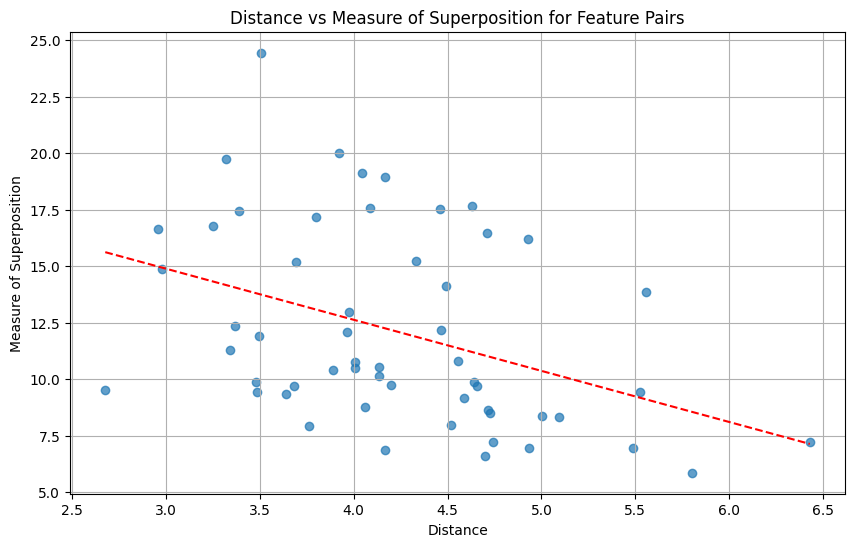

In [22]:
# Plot a 2d scatter plot of the distances and ratios
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['distance'], combined_df['sum_ratios'], alpha=0.7)

# Draw a line of best fit
z = np.polyfit(combined_df['distance'], combined_df['sum_ratios'], 1)
p = np.poly1d(z)
plt.plot(combined_df['distance'], p(combined_df['distance']), color='red', linestyle='--')

plt.title('Distance vs Measure of Superposition for Feature Pairs')
plt.xlabel('Distance')
plt.ylabel('Measure of Superposition')
plt.grid()
plt.show()

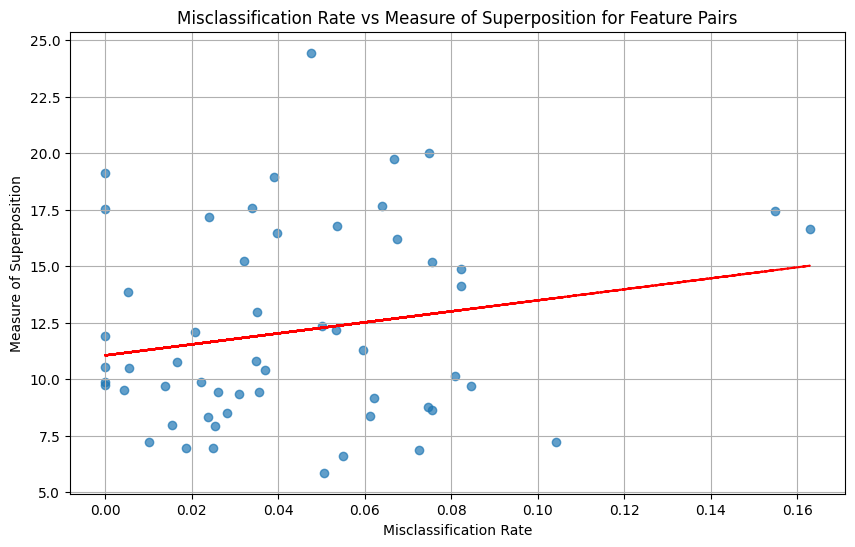

In [23]:
# Plot a 2d scatter plot of the distances and ratios
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['misclassification_rate'], combined_df['sum_ratios'], alpha=0.7)

# Draw a line of best fit
z = np.polyfit(combined_df['misclassification_rate'], combined_df['sum_ratios'], 1)
p = np.poly1d(z)
plt.plot(combined_df['misclassification_rate'], p(combined_df['misclassification_rate']), color='red', linestyle='--')

plt.title('Misclassification Rate vs Measure of Superposition for Feature Pairs')
plt.xlabel('Misclassification Rate')
plt.ylabel('Measure of Superposition')
plt.grid()
plt.show()